This script test OGD using filter data

## Scritp options

In [3]:
first_time = True
full_data= True
copy_processed_full_data = True

copy_processed_sample_data =  False

#================
# for real time modification, restart run time and set variable below to True
copy_py_script = True
# save_model_weights = False

In [4]:
if first_time:
  from google.colab import drive
  drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
if first_time:
  !pip install petastorm[torch]

     |████████████████████████████████| 286kB 12.6MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 212.3MB 74kB/s 
     |████████████████████████████████| 204kB 47.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=fc2df62241c775dbc5a0500eca8f18155e6c5e422888c0c72ce3c336e93361c5
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


## Load libraries

In [6]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter
from petastorm import TransformSpec
import pandas as pd
import torch

## Load the processed data

In [7]:
import pickle
path_processed_features = '/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/1_SparkProcess_AvazuCTR.pickle'
with open(path_processed_features,'rb') as handle:  
  wide_cols = pickle.load(handle)
  interactive_features = pickle.load(handle)
  D = pickle.load(handle)
  embeddings_cols = pickle.load(handle)
  loader_cols = pickle.load(handle)
print('len wide_cols',len(wide_cols))
print('len interactive_features',len(interactive_features))
print('D',D)
print('len embeddings_cols',len(embeddings_cols))
print('len(loader_cols)',len(loader_cols))

print('-----------')

print('- wide_cols',wide_cols)
print('- interactive_features',interactive_features)
print('- D',D)
print('- embeddings_cols',embeddings_cols)
print('- loader_cols',loader_cols)

len wide_cols 23
len interactive_features 0
D 4194304
len embeddings_cols 21
len(loader_cols) 5
-----------
- wide_cols ['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hr', 'dayOfWeek']
- interactive_features []
- D 4194304
- embeddings_cols ['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hr', 'dayOfWeek']
- loader_cols ['id', 'date', 'hashed_wide', 'embedding_indexed', 'label']


In [8]:
embeddings_cols_orig = embeddings_cols.copy()
num_total_wide_features = len(wide_cols) + len(interactive_features)

In [9]:
loader_cols

['id', 'date', 'hashed_wide', 'embedding_indexed', 'label']

In [10]:
# from torch.utils.data import IterableDataset
# import torch
# from torch.utils.data import DataLoader
# import csv

In [11]:
# load petastorm cached data
!mkdir -p /content/petastorm/cache
if copy_processed_full_data:
  !cp -r /content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/petastorm/cache    /content/petastorm
if copy_processed_sample_data:
  !cp -r /content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/petastorm_filtered/cache  /content/petastorm   


In [12]:
# load converter object to local machine
file_name  = 'converter'
if full_data:
  converter_path = F"/content/drive/My Drive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/petastorm/{file_name}.pickle"
else:
  converter_path = F"/content/drive/My Drive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/petastorm_filtered/{file_name}.pickle"

import pickle
with open(converter_path, 'rb') as handle:
    converter_train = pickle.load(handle)
    converter_test = pickle.load(handle)

In [13]:
print(len(converter_train))
print(len(converter_test))
print(converter_train.cache_dir_url)
print(converter_test.cache_dir_url)

36210029
4218938
file:///content/petastorm/cache/20210223004709-appid-local-1614041176244-a6463189-9ba7-4726-a520-271040f9c203
file:///content/petastorm/cache/20210223005632-appid-local-1614041176244-b4c0dbfc-bb62-4f23-9b77-0680efe2326e


## Test dataloader

In [14]:
def get_transform_spec():
  return TransformSpec(func = None, selected_fields = loader_cols)

In [15]:
batch_size = 2
for epoch in range(1):
  with converter_train.make_torch_dataloader(batch_size = batch_size, transform_spec = get_transform_spec(),num_epochs = 1, shuffle_row_groups = True, workers_count = 2) as train_loader, \
       converter_test.make_torch_dataloader(batch_size = batch_size, transform_spec = get_transform_spec(),num_epochs = 1,shuffle_row_groups = True, workers_count = 2) as test_loader:
       for batch_idx, row_batch in enumerate(train_loader):
         break

/usr/local/lib/python3.7/dist-packages/petastorm/arrow_reader_worker.py:53: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  column_as_pandas = column.data.chunks[0].to_pandas()


In [16]:
row_batch.keys()

dict_keys(['id', 'date', 'hashed_wide', 'embedding_indexed', 'label'])

In [17]:
print(row_batch['hashed_wide'].shape) # float32
print(row_batch['embedding_indexed'].shape)
print(row_batch['label'].shape)
print(row_batch['date'].shape)
print(row_batch['id'].shape)

torch.Size([2, 23])
torch.Size([2, 21])
torch.Size([2])
torch.Size([2])
torch.Size([2])


In [18]:
print(row_batch['hashed_wide'].dtype) # float32
print(row_batch['embedding_indexed'].dtype)
print(row_batch['label'].dtype)
print(row_batch['date'].dtype)
print(row_batch['id'].dtype)

torch.float32
torch.float32
torch.float32
torch.int32
torch.float32


## Prepare dictionary ('wd_dataset')

__'embeddings_input'__ : this info will be used to specify the dimensionality of embedding matrix

In [19]:
embeddings_dim = {}

In [20]:
embeddings_cols = [(col, 32) for col in embeddings_cols]

In [21]:
#get cardinaliy
if full_data:
  pdf_cardinality = pd.read_csv("/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/Data/full_cardinality.csv")
else:
  pdf_cardinality = pd.read_csv("/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/Data/filtered_cardinality.csv")
pdf_cardinality['dayOfWeek'] = 7
pdf_cardinality.head()

,Unnamed: 0,total,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hr,dayOfWeek
0,0,40428967,7,7,4737,7745,26,8552,559,36,2686408,6729486,8251,5,4,2626,8,9,435,4,68,172,60,24,7


In [22]:
pdf_cardinality[wide_cols].sum(axis = 1)

0    9449236
dtype: int64

In [23]:
wd_dataset = {}
wd_dataset['embeddings_input'] = [(col,pdf_cardinality.loc[0,col],dim) for col, dim in embeddings_cols]
wd_dataset['embeddings_input']

[('C1', 7, 32),
 ('banner_pos', 7, 32),
 ('site_id', 4737, 32),
 ('site_domain', 7745, 32),
 ('site_category', 26, 32),
 ('app_id', 8552, 32),
 ('app_domain', 559, 32),
 ('app_category', 36, 32),
 ('device_model', 8251, 32),
 ('device_type', 5, 32),
 ('device_conn_type', 4, 32),
 ('C14', 2626, 32),
 ('C15', 8, 32),
 ('C16', 9, 32),
 ('C17', 435, 32),
 ('C18', 4, 32),
 ('C19', 68, 32),
 ('C20', 172, 32),
 ('C21', 60, 32),
 ('hr', 24, 32),
 ('dayOfWeek', 7, 32)]

__'deep_column_idx'__: 
- used to tell deep model which feature being looking at, so that model knows which imbedding matrix to look at
- map from col to column index within deep side array/tensor (essentially a matrix), and it looks like below:

{'age': 5,
 'education': 0,
 'hours_per_week': 6,
 'native_country': 4,
 'occupation': 3,
 'relationship': 1,
 'workclass': 2}

In [24]:
embeddings_cols_orig

['C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_model',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'hr',
 'dayOfWeek']

In [25]:
wd_dataset['deep_column_idx'] = {col: i for i,col in enumerate(embeddings_cols_orig)}
wd_dataset['deep_column_idx']

{'C1': 0,
 'C14': 11,
 'C15': 12,
 'C16': 13,
 'C17': 14,
 'C18': 15,
 'C19': 16,
 'C20': 17,
 'C21': 18,
 'app_category': 7,
 'app_domain': 6,
 'app_id': 5,
 'banner_pos': 1,
 'dayOfWeek': 20,
 'device_conn_type': 10,
 'device_model': 8,
 'device_type': 9,
 'hr': 19,
 'site_category': 4,
 'site_domain': 3,
 'site_id': 2}

In [26]:
# not using it rightnow
# ordered_wide_cols =wide_cols
# wd_dataset['wide_column_idx'] =  {col: i for i,col in enumerate(ordered_wide_cols)}

In [27]:
# Network set up

deep_column_idx = wd_dataset['deep_column_idx']
embeddings_input= wd_dataset['embeddings_input']

##Copy py scripts

In [28]:

if copy_py_script:
  !cp -R /content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/DEV_CODES/WDL_FTRL_model.py . # overwriting if necessary
  !cp -R /content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/DEV_CODES/utility.py .


In [29]:
from utility import *


##BUILD THE MODEL

 it is [reported](https://towardsdatascience.com/curse-of-batch-normalization-8e6dd20bc304) that batch normalization is hurt the performance of small batch data, which is the case for online learning.

In [30]:
# model
hidden_layers = [1024,512,256] 
batch_norm = True
dropout = [0, 0, 0]
continuous_cols = []
n_class=1 
D = 2 ** 22


In [31]:
# Build the model. Again you just need to call WideDeep, model will use cuda automatically if available
from WDL_FTRL_model import WideDeep
model = WideDeep(embeddings_input,continuous_cols, deep_column_idx,hidden_layers,batch_norm, dropout, n_class, num_total_wide_features, D = D)
model.init_train_history()

In [32]:
# put model to cuda if possible
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# print(torch.cuda.get_device_name(device))
model = model.to(device)

print('Detailed No. of parameters')
for name,param in model.named_parameters():
    if param.requires_grad == True:
        print("\t",name,',',param.numel())

print('Total number of parameters')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

cuda:0
Detailed No. of parameters
	 emb_layer_C1.weight , 224
	 emb_layer_banner_pos.weight , 224
	 emb_layer_site_id.weight , 151584
	 emb_layer_site_domain.weight , 247840
	 emb_layer_site_category.weight , 832
	 emb_layer_app_id.weight , 273664
	 emb_layer_app_domain.weight , 17888
	 emb_layer_app_category.weight , 1152
	 emb_layer_device_model.weight , 264032
	 emb_layer_device_type.weight , 160
	 emb_layer_device_conn_type.weight , 128
	 emb_layer_C14.weight , 84032
	 emb_layer_C15.weight , 256
	 emb_layer_C16.weight , 288
	 emb_layer_C17.weight , 13920
	 emb_layer_C18.weight , 128
	 emb_layer_C19.weight , 2176
	 emb_layer_C20.weight , 5504
	 emb_layer_C21.weight , 1920
	 emb_layer_hr.weight , 768
	 emb_layer_dayOfWeek.weight , 224
	 linear_0.weight , 688128
	 bn0.weight , 1024
	 bn0.bias , 1024
	 linear_1.weight , 524288
	 bn_1.weight , 512
	 bn_1.bias , 512
	 linear_2.weight , 131072
	 bn_2.weight , 256
	 bn_2.bias , 256
	 final_partial_fc.weight , 256
	 final_partial_fc.bias , 

In [33]:
model

WideDeep(
  (emb_layer_C1): Embedding(7, 32)
  (emb_layer_banner_pos): Embedding(7, 32)
  (emb_layer_site_id): Embedding(4737, 32)
  (emb_layer_site_domain): Embedding(7745, 32)
  (emb_layer_site_category): Embedding(26, 32)
  (emb_layer_app_id): Embedding(8552, 32)
  (emb_layer_app_domain): Embedding(559, 32)
  (emb_layer_app_category): Embedding(36, 32)
  (emb_layer_device_model): Embedding(8251, 32)
  (emb_layer_device_type): Embedding(5, 32)
  (emb_layer_device_conn_type): Embedding(4, 32)
  (emb_layer_C14): Embedding(2626, 32)
  (emb_layer_C15): Embedding(8, 32)
  (emb_layer_C16): Embedding(9, 32)
  (emb_layer_C17): Embedding(435, 32)
  (emb_layer_C18): Embedding(4, 32)
  (emb_layer_C19): Embedding(68, 32)
  (emb_layer_C20): Embedding(172, 32)
  (emb_layer_C21): Embedding(60, 32)
  (emb_layer_hr): Embedding(24, 32)
  (emb_layer_dayOfWeek): Embedding(7, 32)
  (linear_0): Linear(in_features=672, out_features=1024, bias=False)
  (bn0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affin

## load pretrained models:


In [ ]:
model_deep = torch.load(F'/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/OGD_deepOnly_iter_6.pth')
model_wide = torch.load(F'/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/OGD_wideOnly_iter_3.pth')

In [ ]:
#deep part
model.load_state_dict(model_deep.best_model_wts)

#wide part
model.w = model_wide.w
model.b = model_wide.b

##OPTIMIZER (and regularization)

In [ ]:
#======compile optimizer 
#--deep
selected_weight_decay = 0 
learning_rate = 0.001         #deep lr
momentum = 0.9 #applied to SGD

#--wide
lr_w = 0.001
L2_decay = 0


#------use 'Per-parameter options' of torch.optim
from utility import customize_para_group_1
parameter_groups,decay_name,no_decay_name = customize_para_group_1(model,selected_weight_decay)
print('Parameter Groups:')
from pprint import pprint
print('----no_decay_parameters----')
pprint(no_decay_name)
print('----decay_parameters-----')
pprint(decay_name)


#-compile optimizer
optimizer = torch.optim.SGD(parameter_groups, lr=learning_rate, momentum = momentum, weight_decay = 0)
model.compile(optimizer=optimizer,lr_w = lr_w,L2_decay = L2_decay)

Parameter Groups:
----no_decay_parameters----
['emb_layer_C1.weight',
 'emb_layer_banner_pos.weight',
 'emb_layer_site_id.weight',
 'emb_layer_site_domain.weight',
 'emb_layer_site_category.weight',
 'emb_layer_app_id.weight',
 'emb_layer_app_domain.weight',
 'emb_layer_app_category.weight',
 'emb_layer_device_model.weight',
 'emb_layer_device_type.weight',
 'emb_layer_device_conn_type.weight',
 'emb_layer_C14.weight',
 'emb_layer_C15.weight',
 'emb_layer_C16.weight',
 'emb_layer_C17.weight',
 'emb_layer_C18.weight',
 'emb_layer_C19.weight',
 'emb_layer_C20.weight',
 'emb_layer_C21.weight',
 'emb_layer_hr.weight',
 'emb_layer_dayOfWeek.weight',
 'bn0.weight',
 'bn0.bias',
 'bn_1.weight',
 'bn_1.bias',
 'bn_2.weight',
 'bn_2.bias',
 'final_partial_fc.bias']
----decay_parameters-----
['linear_0.weight',
 'linear_1.weight',
 'linear_2.weight',
 'final_partial_fc.weight']


##MODEL TRAINING

### 1st epoch: 
- lr = 0.001 (wide and deep), 
- no decay

In [ ]:
#-------moel training:
batch_size = 32
shuffle_row_groups = True
n_epochs = 1
num_print_per_epoch = 3
from utility import calc_batch_interval
batch_interval = calc_batch_interval(num_print_per_epoch,full_data,batch_size)

model.fit(converter_train, converter_test, batch_interval, loader_cols, n_epochs, batch_size, shuffle_row_groups = shuffle_row_groups)
model.decay_catch_up() # finish weights decay for all weights on the wide side
#------save model:
import torch
torch.save(model,F'/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/OGD_combine_iter_1.pth')

#-------plot training history:
from utility import plot_training_stats
plot_training_stats(model.train_loss_history,model.test_loss_history[1:])



```
/usr/local/lib/python3.7/dist-packages/petastorm/arrow_reader_worker.py:53: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  column_as_pandas = column.data.chunks[0].to_pandas()
Current test loss: 0.4833. So far best test loss: 0.4833
======
time: 22:22:13
-----
time: 00:57:38
batch 377187, avg training loss 0.388 per sample within batches
Current test loss: 0.4015. So far best test loss: 0.4015
-----
time: 03:58:58
batch 754374, avg training loss 0.388 per sample within batches
Current test loss: 0.3986. So far best test loss: 0.3986
-----
time: 07:04:51
batch 1131561, avg training loss 0.388 per sample within batches
Current test loss: 0.3975. So far best test loss: 0.3975
```



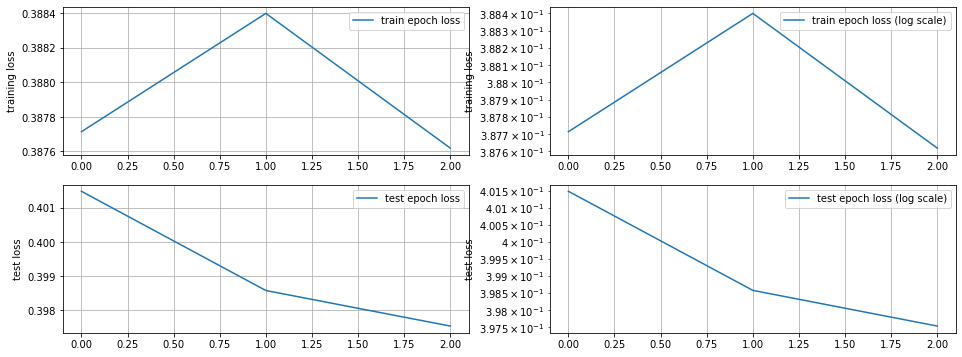

In [34]:
# plot function was used in a wrong way, so did it again
import torch
model = torch.load(F'/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/OGD_combine_iter_1.pth')
from utility import plot_training_stats
plot_training_stats(model.train_loss_history,model.test_loss_history[1:])

### 2nd epoch: 
- lr = 0.001 (wide and deep)
- no decay

In [ ]:
#-------moel training:
batch_size = 32
shuffle_row_groups = True
n_epochs = 1
num_print_per_epoch = 3
from utility import calc_batch_interval
batch_interval = calc_batch_interval(num_print_per_epoch,full_data,batch_size)

model.fit(converter_train, converter_test, batch_interval, loader_cols, n_epochs, batch_size, shuffle_row_groups = shuffle_row_groups)
model.decay_catch_up() # finish weights decay for all weights on the wide side
#------save model:
import torch
torch.save(model,F'/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/OGD_combine_iter_2.pth')

#-------plot training history:
from utility import plot_training_stats
plot_training_stats(model.train_loss_history,model.test_loss_history[1:])



```
/usr/local/lib/python3.7/dist-packages/petastorm/arrow_reader_worker.py:53: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  column_as_pandas = column.data.chunks[0].to_pandas()
Current test loss: 0.3979. So far best test loss: 0.3975
======
time: 07:50:46
-----
time: 10:33:38
batch 377187, avg training loss 0.386 per sample within batches
Current test loss: 0.4080. So far best test loss: 0.3975
-----
time: 13:34:12
batch 754374, avg training loss 0.387 per sample within batches
Current test loss: 0.3982. So far best test loss: 0.3975
-----
time: 16:35:19
batch 1131561, avg training loss 0.386 per sample within batches
Current test loss: 0.3998. So far best test loss: 0.3975
```



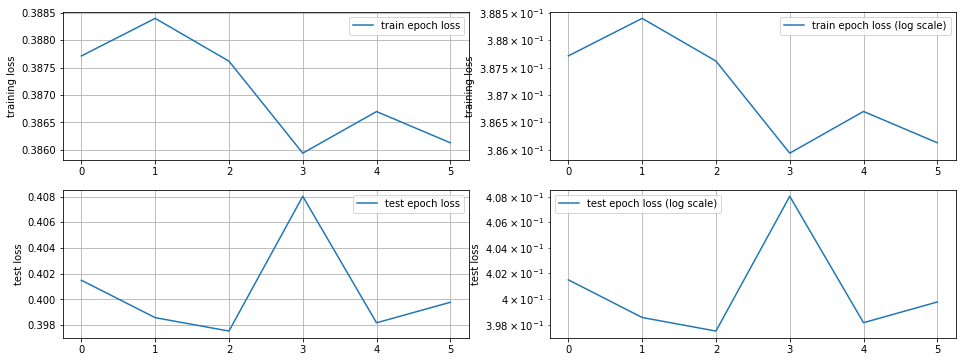

In [35]:
# plot function was used in a wrong way, so did it again
import torch
model = torch.load(F'/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/OGD_combine_iter_2.pth')
from utility import plot_training_stats
plot_training_stats(model.train_loss_history,model.test_loss_history[1:4] + model.test_loss_history[5:5+3])

### 3rd epoch:
- lr = 0.001 (wide and deep)
- deep decay: 1e-4 
- wide decay: 0

In [ ]:
#======compile optimizer 
#--deep
selected_weight_decay = 1e-4 
learning_rate = 0.001         #deep lr
momentum = 0.9 #applied to SGD

#--wide
lr_w = 0.001
L2_decay = 0


#------use 'Per-parameter options' of torch.optim
parameter_groups,decay_name,no_decay_name = customize_para_group_1(model,selected_weight_decay)

#-prepare optimizer for deep
optimizer = torch.optim.SGD(parameter_groups, lr=learning_rate, momentum = momentum, weight_decay = 0)

# load model
model = torch.load(F'/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/OGD_combine_iter_2.pth')

# compile optimizers
model.compile(optimizer=optimizer,lr_w = lr_w,L2_decay = L2_decay)

#-------moel training:
batch_size = 32
shuffle_row_groups = True
n_epochs = 1
num_print_per_epoch = 3
batch_interval = calc_batch_interval(num_print_per_epoch,full_data,batch_size)

model.fit(converter_train, converter_test, batch_interval, loader_cols, n_epochs, batch_size, shuffle_row_groups = shuffle_row_groups)
model.decay_catch_up() # finish weights decay for all weights on the wide side
#------save model:
import torch
torch.save(model,F'/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/OGD_combine_iter_3.pth')

#-------plot training history:
from utility import plot_training_stats
plot_training_stats(model.train_loss_history,model.test_loss_history[1:4] + model.test_loss_history[5:5+3] + model.test_loss_history[5+3+1:5+3+1+3])

/usr/local/lib/python3.7/dist-packages/petastorm/arrow_reader_worker.py:53: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  column_as_pandas = column.data.chunks[0].to_pandas()


Current test loss: 0.3996. So far best test loss: 0.3975
time: 19:34:49


# Calculate ROC AUC

In [ ]:
# # wide and deep
# model = torch.load(F'/content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/WDL_FTRL/data_wDash/OGD_combine_iter_1.pth')
# from sklearn.metrics import roc_auc_score   
# y_test,probas = prepare_ROC_AUC(model,converter_test,loader_cols,'OGD')
# roc_auc = roc_auc_score(y_test, probas)
# roc_auc

# end